In [1]:
from models.model import UNET
import numpy as np
from torch import nn
import torch
import torch.nn.functional as F
import imageio
from tqdm import tqdm
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import torchvision
from src.data.data_utils import get_slice_idxs, slice_image, unslice_images
from src.models.predict_model import SegmentImage

In [20]:
predict = SegmentImage(UNET, "../models/checkpoints/epoch=11-step=6624.ckpt")
image_path = "../data/raw/images/TCGA-AN-A0AR-DX1_xmin8468_ymin21166_MPP-0.2500.png"
mask_path = "../data/raw/masks/TCGA-AN-A0AR-DX1_xmin8468_ymin21166_MPP-0.2500.png"
image = torchvision.io.read_image(image_path).to(torch.float) / 255.0
mask = torchvision.io.read_image(mask_path).to(torch.int)
mask[mask > 4] = 5
pred = predict(image)

100%|██████████| 210/210 [00:30<00:00,  6.96it/s]


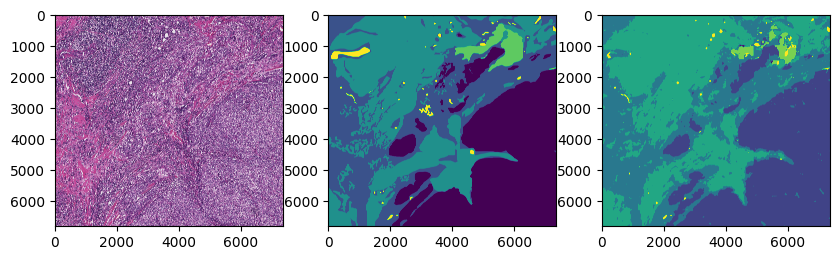

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(torch.moveaxis(image, 0, -1))
ax[1].imshow(mask[0])
ax[2].imshow(pred)
plt.show()